In [1]:
import numpy as np
import os
dtype = np.float32

import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import os

from transformers import CLIPVisionModelWithProjection, AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer, OPTForCausalLM, BloomForCausalLM
import numpy

from huggingface_hub import try_to_load_from_cache, _CACHED_NO_EXIST
from huggingface_hub import scan_cache_dir

import glob
import random
import json
import os

device = torch.device("cuda:0")
# device = torch.device("cpu")

def get_named_linears(module):
    return {name: m for name, m in module.named_modules() if isinstance(m, nn.Linear)}

def get_blocks(model):
    if model.__class__.__name__ in ("LlamaForCausalLM", "Qwen2ForCausalLM"):
        layers = model.model.layers
    elif model.__class__.__name__ == "LlavaLlamaForCausalLM":
        layers = model.model.layers
    elif isinstance(model, OPTForCausalLM):
        layers = model.model.decoder.layers
    elif isinstance(model, BloomForCausalLM):
        layers = model.transformer.h
    elif "mpt" in str(model.__class__).lower():
        layers = model.transformer.blocks
    elif "falcon" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "bigcode" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "neox" in str(model.__class__).lower():
        layers = model.gpt_neox.layers
    elif model.__class__.__name__ == "LlavaLlamaModel":
        layers = model.llm.model.layers
    elif model.__class__.__name__ in ("CLIPModel"):
        vision_layers = model.vision_model.encoder.layers
        text_layers = model.text_model.encoder.layers
        layers = {'vision': vision_layers,
                  'text': text_layers}
    else:
        raise NotImplementedError(type(model))
    # if not isinstance(layers, dict):
    #     layers = {'': layers}
    return layers

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dignal Scaled RHT Weight Block

많이 수정함

In [2]:
def flat_to_sym(V, N):
    A = torch.zeros(N, N, dtype=V.dtype, device=V.device)
    idxs = torch.tril_indices(N, N, device=V.device)
    A[idxs.unbind()] = V
    A[idxs[1, :], idxs[0, :]] = V
    return A

def regularize_H(H, n, sigma_reg):
    H.div_(torch.diag(H).mean())
    idx = torch.arange(n)
    H[idx, idx] += sigma_reg
    return H

import sys
sys.path.append('/workspace/Weight_compression/Wparam_dataset')
from utils import *

def RHT_H(H, SU):
    return matmul_hadUt(matmul_hadUt(H * SU).T * SU)

def RHT_W(W, SU, SV):
    return matmul_hadUt(matmul_hadUt(W.T * SV).T * SU)

def incoherence_preprocess(H, W, args):
    # dtype_ = torch.float64 if args.use_fp64 else torch.float32
    dtype_ = torch.float32
    device = H.device
    # device = torch.device('cpu')
    (m, n) = H.shape

    def _dump(Hr, Lhr, msg=''):
        torch.save(Hr, f"{args.save_pfx}/Hr_debug_fft.pt")
        torch.save(Lhr, f"{args.save_pfx}/Lhr_debug_fft.pt")
        raise Exception(msg)

    # diagonally rescale W,H to minimize proxy loss
    scaleWH = None
    Wr = W
    Hr = H
    # if args.rescale_WH:
    if False:
        Hr = H / H.abs().max()
        diagH = torch.diag(Hr)
        diagW2 = torch.diag(W.T @ W)
        diagH = torch.clamp(diagH, min=1e-8)
        diagW2 = torch.clamp(diagW2, min=1e-8)
        scaleWH = (diagH / diagW2).sqrt().sqrt().to(torch.float32)
        scaleWH = scaleWH.clamp(min=1e-8)
        Wr = Wr * scaleWH[None, :]
        Hr = Hr / scaleWH[None, :]
        Hr = Hr / scaleWH[:, None]
        scaleWH = scaleWH.cpu()

    # randomized hadamard transformation on H, W
    if True:
        SU = (torch.randn(n, device=device).sign() + 1e-5).sign().to(dtype_)
        SV = (torch.randn(m, device=device).sign() + 1e-5).sign().to(dtype_)
        Hr = RHT_H(Hr, SU)
        # Wr = RHT_W(Wr, SU, SV)
    # randomized kronecker product on H, W
    elif args.incoh_mode == "kron":
        SU = utils.rand_ortho_butterfly_noblock(n).to(dtype_).to(device)
        SV = utils.rand_ortho_butterfly_noblock(m).to(dtype_).to(device)
        Hr = SU @ Hr @ SU.T
        Wr = SV @ Wr @ SU.T
    else:
        raise NotImplementedError
    SV = SV.cpu()
    SU = SU.cpu()

    # Lhr = torch.linalg.cholesky(Hr)
    Lhr = None
    # if not torch.all(torch.isfinite(Lhr)):
    #     return None

    # Wr = Wr.to(device)

    return Lhr, Hr, Wr, SU, SV, scaleWH

### V2

In [ ]:
import matplotlib.pyplot as plt
model_list = [
    'meta-llama/Meta-Llama-3-8B',
    # 'meta-llama--Llama-2-7b-hf'
]
quip_hess_path = [
    './quip_hess/llama3_8b_6144',
    # './quip_hess/Hessians-Llama-2-7b-6144',
]
quip_hess_eig_path = [
    # './quip_hess_eig_reg0.0001/llama3_8b_6144',
    None
]

size_list = [
    1024,
    # 256,
    # 4096
]

wtype_mapping = {'self_attn.q_proj': 0, 
                 'self_attn.k_proj': 1, 
                 'self_attn.v_proj': 2, 
                 'self_attn.o_proj': 3, 
                 'mlp.gate_proj': 4, 
                 'mlp.up_proj': 5, 
                 'mlp.down_proj': 6}
sigma_reg = 1e-4
direction = 'col'
# direction = 'row'

global_std = 0.012529

for model_name, size, quip_hess, eig_path in zip(model_list, size_list, quip_hess_path, quip_hess_eig_path):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)
    
    raw_data = {}
    raw_data['weight'] = []
    raw_data['idx'] = []
    raw_data['layer_type'] = []
    raw_data['scale'] = []
        
    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        
        hess_dict = {}
        hess_dict['qkv'] = torch.load(f'{quip_hess}/{i}_qkv.pt', weights_only=False)
        hess_dict['o'] = torch.load(f'{quip_hess}/{i}_o.pt', weights_only=False)
        hess_dict['up'] = torch.load(f'{quip_hess}/{i}_up.pt', weights_only=False)
        hess_dict['down'] = torch.load(f'{quip_hess}/{i}_down.pt', weights_only=False)
        
        # hess_eig_dict = {}
        # hess_eig_dict['qkv'] = torch.load(f'{eig_path}/{i}_qkv_eig.pt', weights_only=False)
        # hess_eig_dict['o'] = torch.load(f'{eig_path}/{i}_o_eig.pt', weights_only=False)
        # hess_eig_dict['up'] = torch.load(f'{eig_path}/{i}_up_eig.pt', weights_only=False)
        # hess_eig_dict['down'] = torch.load(f'{eig_path}/{i}_down_eig.pt', weights_only=False)
        
        for n, m in named_linears.items():
            
            W = m.weight.data.detach().to(device)
            
            if 'q_proj' in n or 'k_proj' in n or 'v_proj' in n:
                H_flat = hess_dict['qkv']
                # H_eig = hess_eig_dict['qkv']
            elif 'o_proj' in n:
                H_flat = hess_dict['o']
                # H_eig = hess_eig_dict['o']
            elif 'up_proj' in n or 'gate_proj' in n:
                H_flat = hess_dict['up']
                # H_eig = hess_eig_dict['up']
            elif 'down_proj' in n:
                H_flat = hess_dict['down']
                # H_eig = hess_eig_dict['down']
            else:
                raise NotImplementedError(n)
            
            H = flat_to_sym(H_flat['flatH'], H_flat['n']).to(device)
            mu = H_flat['mu'].to(device)
            H.add_(mu[None, :] * mu[:, None])
            n_h = H_flat['n']

            # print('before',torch.diag(H).mean())
            H = regularize_H(H, n_h, sigma_reg)
            # print('after',torch.diag(H).mean())
            
            #############################################
            ## scaleH_rnormed_scale_cond(col_std)
            diagH = torch.diag(H)
            diagH = torch.clamp(diagH, min=1e-8)
            scaleH = diagH.sqrt()
            Wr = W * scaleH[None, :]
            # Wr = Wr / Wr.norm(p=2, dim=1, keepdim=True)
            Wr = Wr / Wr.std(dim=1, keepdim=True)
            
            col_std = Wr.std(dim=0, keepdim=True)
            scale_cond = col_std
            scale_cond = scale_cond.repeat(Wr.shape[0], 1)
            
            #############################################
            ## _rnormed_scale_cond(scaleWH)
            # row normalize
            # Wr = W / W.std(dim=1, keepdim=True)
            # Wr = W / global_std
            
            # compute scaleH
            # diagH = torch.diag(H)
            # diagH = torch.clamp(diagH, min=1e-8)
            # scaleH = diagH.sqrt()      
            
            # compute scale
            # col_std = Wr.std(dim=0, keepdim=False)
            # scale_cond = scaleH / col_std
            # scale_cond = scale_cond[None, :]
            # scale_cond = scale_cond.repeat(Wr.shape[0], 1)
            # assert scale_cond.shape == Wr.shape            
            
            #############################################
            ## _whiten_scale_cond(col_std)
            
            # U = H_eig['eigenvectors'].to(W.device).to(W.dtype)       # [n, k] (k=n이면 full)
            # Lam = H_eig['eigenvalues'].to(W.device).to(W.dtype).flatten()  # [k]

            # # sqrt(Λ): η = 1/2
            # eps = 1e-12
            # sqrtLam = Lam.clamp_min(eps).pow(0.5)                    # [k]
            # inv_sqrtLam = Lam.clamp_min(eps).pow(-0.5)               # 복원 시 필요

            # # Z = (W @ U) * sqrtLam  (열별 스케일링)
            # WU = W @ U                                               # [out, k]
            # Z  = WU * sqrtLam                                       

            # Wr = Z
            # scale_cond = Wr.std(dim = 0, keepdim=True).expand(Wr.shape[0], -1).contiguous()
            # # scale_cond = sqrtLam.unsqueeze(0).expand(Wr.shape[0], -1).contiguous()
            
            # assert scale_cond.shape == Wr.shape

            #############################################
            ## _rnormed_scale_cond(col_std)
            # Wr = W / W.std(dim=1, keepdim=True)
            
            # col_std = Wr.std(dim=0, keepdim=True)
            # scale_cond = col_std
            # scale_cond = scale_cond.repeat(Wr.shape[0], 1)
            # assert scale_cond.shape == Wr.shape   
            #############################################

            if direction == 'col':
                w = Wr.T.to('cpu')
                s = scale_cond.T.to('cpu')
            else:
                assert Wr.shape[1] % size == 0
                w = Wr.to('cpu')
                s = scale_cond.to('cpu')
                           
            if w.shape[-1] % size == 0:
                w = w.reshape(-1, size)
                s = s.reshape(-1, size)
            else:
                raise
            
            ## col_1024_scaleH_rnorm_scale_cond(col_std)
            assert torch.all(s == s[..., :1])
            s = s[..., :1]

            raw_data['weight'].append(w)
            raw_data['scale'].append(s)
            
            idx = torch.tensor([i], dtype = torch.int8)
            raw_data['idx'].extend([idx] * w.shape[0])
            
            layer_type = torch.tensor([wtype_mapping[n]], dtype = torch.int8)
            raw_data['layer_type'].extend([layer_type] * w.shape[0])
    
    for k in raw_data.keys():
        # if datas[k][0].shape == torch.Size([]):
        #     datas[k] = torch.tensor(datas[k])
        # else:
        raw_data[k] = torch.cat(raw_data[k], dim = 0)
        print(f'{k} total shape: ', raw_data[k].shape)
    
    ###################### split, compute stats
    
    indices = torch.randperm(len(raw_data['weight']))
    split_index = int(len(raw_data['weight']) - 1000)
    train_indices = indices[:split_index]
    val_indices = indices[split_index:]

    dataset = {}
    dataset['train'] = {}
    dataset['val'] = {}
    for k in raw_data.keys():
        dataset['train'][k] = raw_data[k][train_indices]
        dataset['val'][k] = raw_data[k][val_indices]
        
    print('train Weight: ', dataset['train']['weight'].shape, 'val: ', dataset['val']['weight'].shape)
    print('train Scale: ', dataset['train']['scale'].shape, 'val: ', dataset['val']['scale'].shape)

    dataset_stats = {}
    for split in ['train', 'val']:
        data = dataset[split]
        
        # mean_dim0 = data['weight'].mean(dim=0)
        # std_dim0 = data['weight'].std(dim=0)
        
        mean_all = data['weight'].mean()
        std_all = data['weight'].std()
        
        dataset_stats[split] = {
            'mean': mean_all.item(),
            'std': std_all.item(),
            'mean_channel': None,
            'std_channel': None
        }
        
    ###################### save
    
    print('Scale stats:', dataset['train']['scale'].mean(), dataset['train']['scale'].min(), dataset['train']['scale'].max())
    os.makedirs(f'./block_pt/{model_name}', exist_ok = True)
    
    ###################### 
    # torch.save(dataset, f'./block_pt/{model_name}/{direction}_{size}_rnormed_scale_cond(scaleWH).pt')
    # json_path = f'./block_pt/{model_name}/{direction}_{size}_rnormed_scale_cond(scaleWH)_dataset_stats.json'
    # torch.save(dataset, f'./block_pt/{model_name}/{direction}_{size}_scale_cond(scaleWH).pt')
    # json_path = f'./block_pt/{model_name}/{direction}_{size}_scale_cond(scaleWH)_dataset_stats.json'
    # torch.save(dataset, f'./block_pt/{model_name}/{direction}_{size}_whiten_scale_cond(col_std).pt')
    # json_path = f'./block_pt/{model_name}/{direction}_{size}_whiten_scale_cond(col_std)_dataset_stats.json'
    # torch.save(dataset, f'./block_pt/{model_name}/{direction}_{size}_rnormed_scale_cond(col_std).pt')
    # json_path = f'./block_pt/{model_name}/{direction}_{size}_rnormed_scale_cond(col_std)_dataset_stats.json'
    torch.save(dataset, f'./block_pt/{model_name}/{direction}_{size}_scaleH{sigma_reg}_rnormed_scale_cond(col_std).pt')
    json_path = f'./block_pt/{model_name}/{direction}_{size}_scaleH{sigma_reg}_rnormed_scale_cond(col_std)_dataset_stats.json'
    ###################### 
    with open(json_path, 'w') as f:
        json.dump(dataset_stats, f)
    

# plot diag(H)

model_name:  meta-llama--Meta-Llama-3-8B


Loading checkpoint shards: 100%|██████████| 7/7 [00:01<00:00,  5.10it/s]


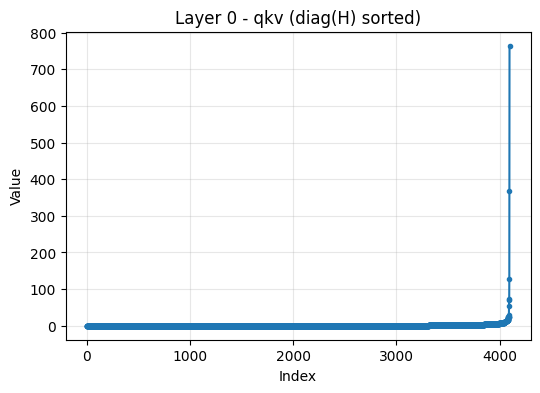

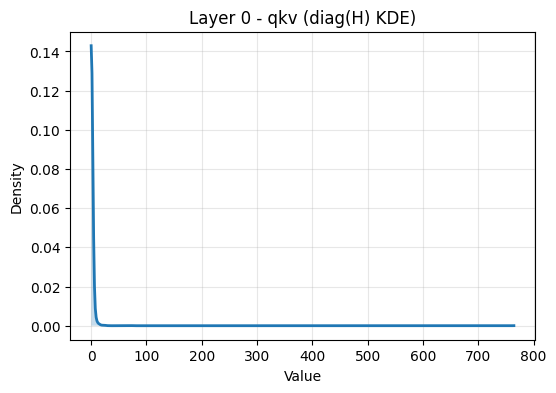

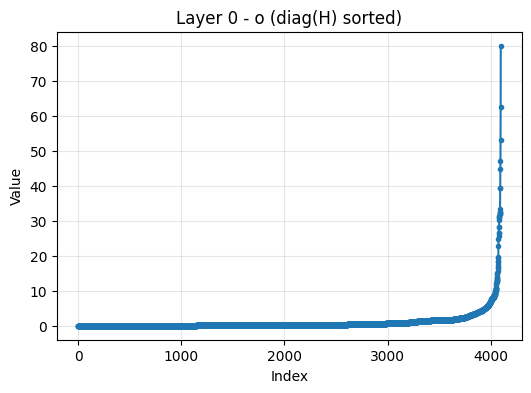

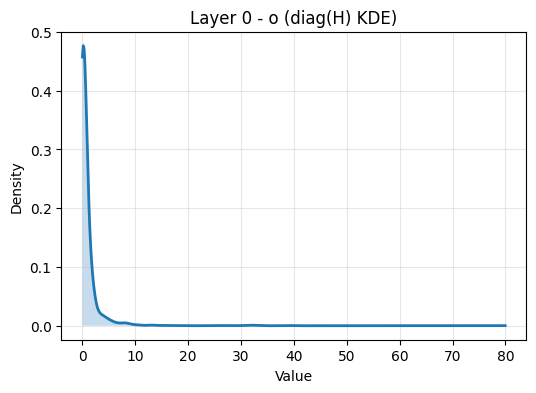

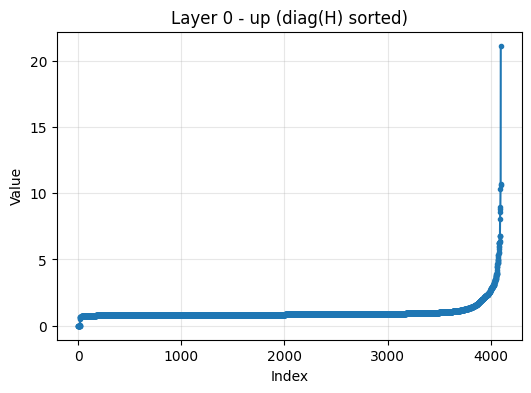

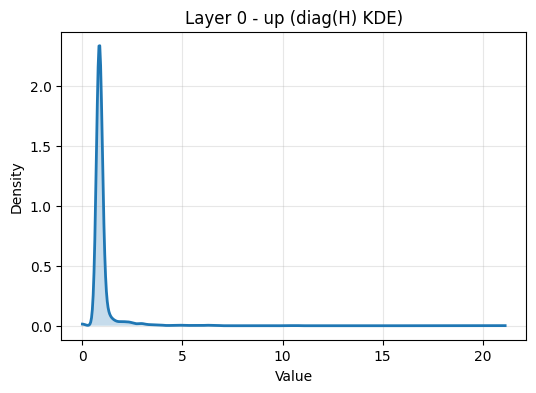

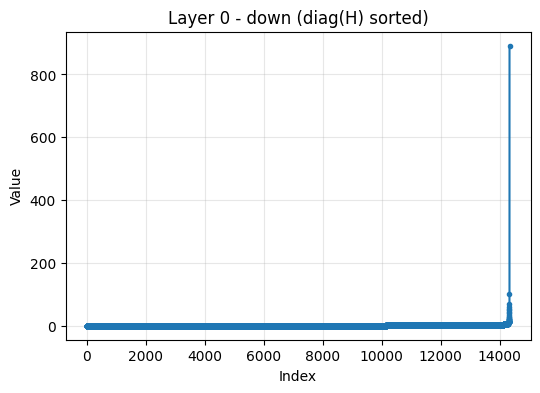

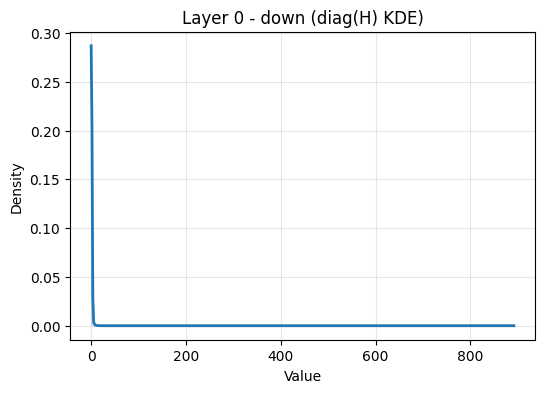

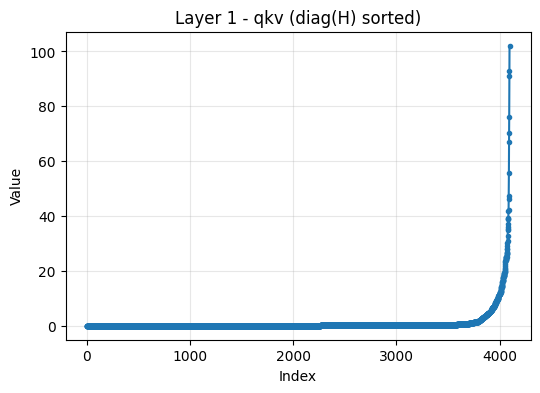

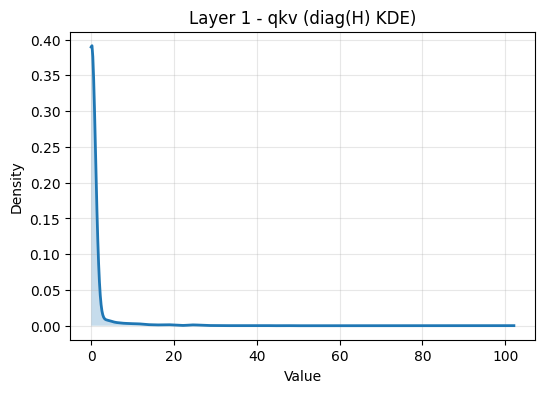

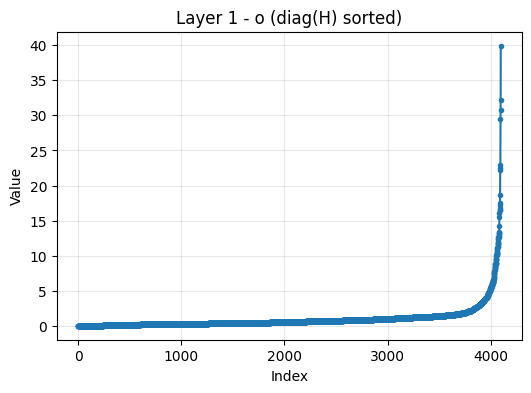

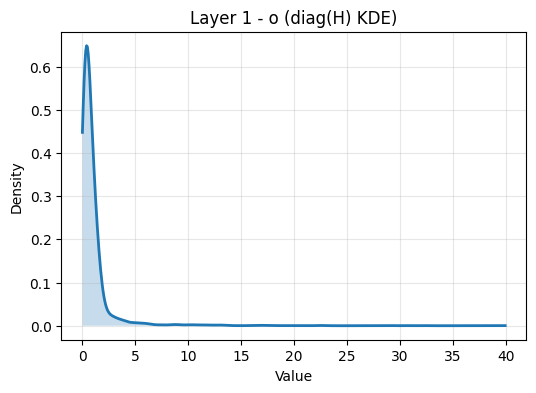

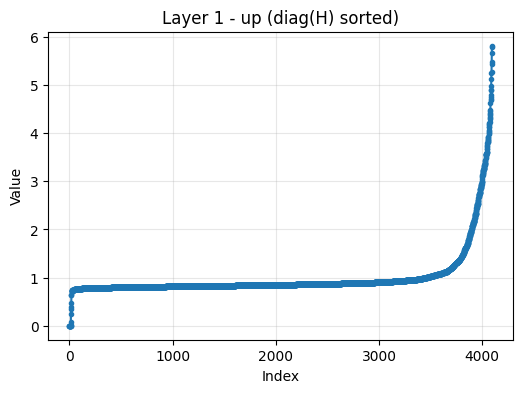

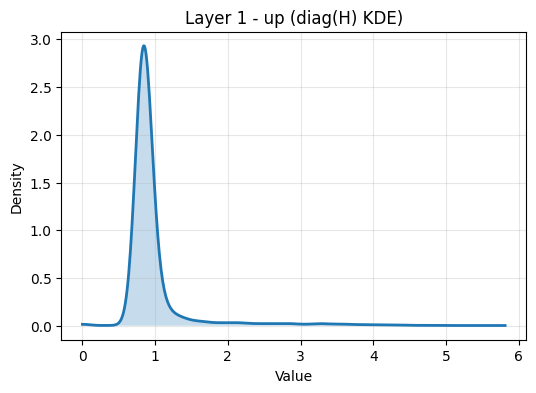

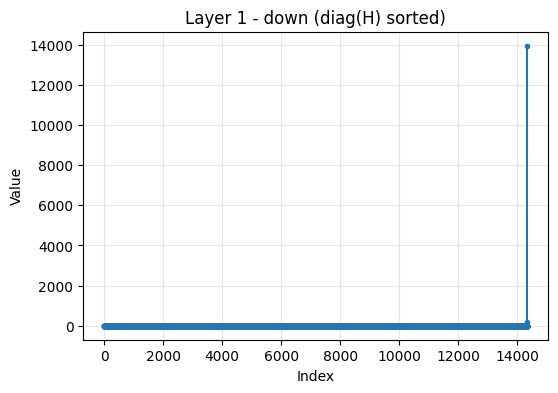

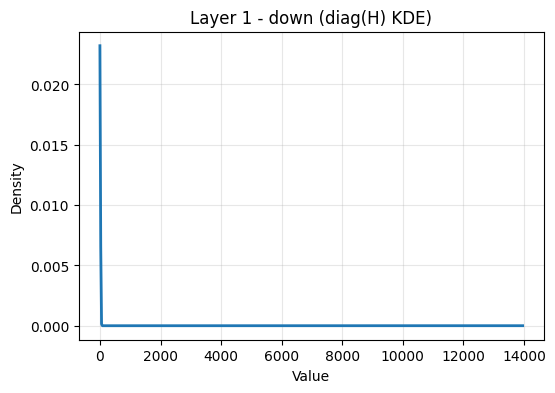

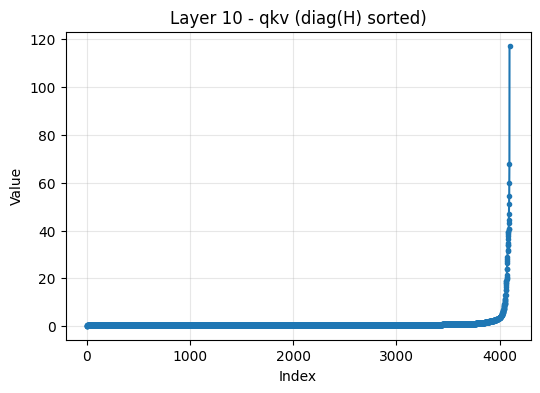

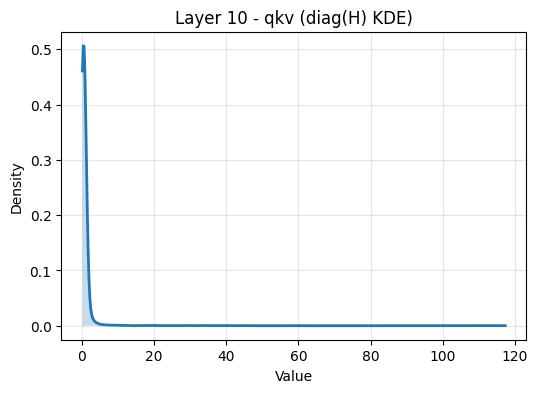

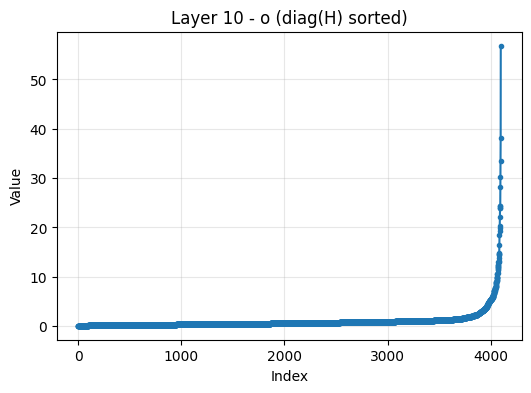

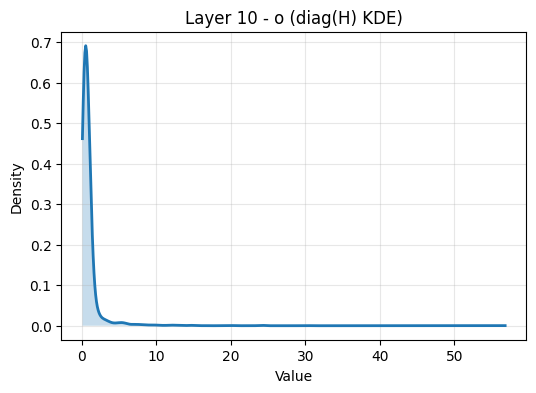

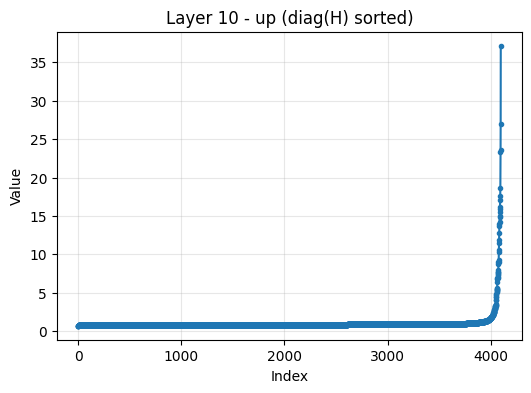

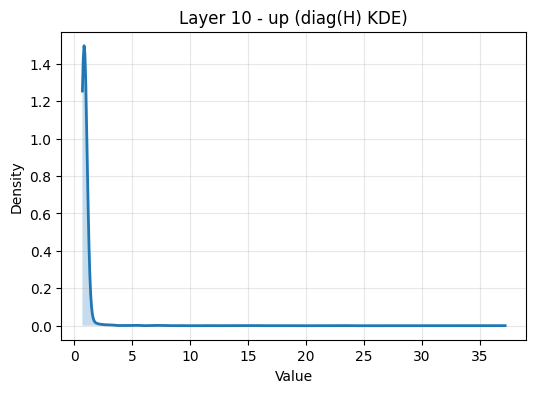

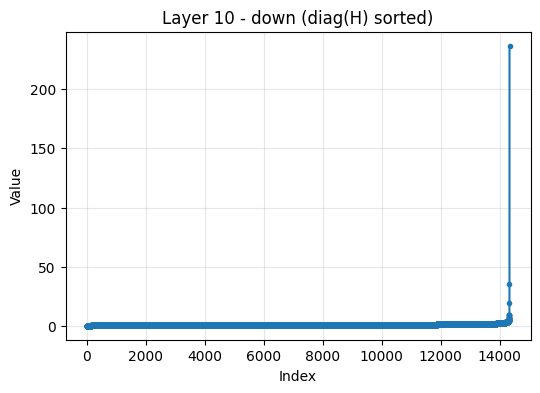

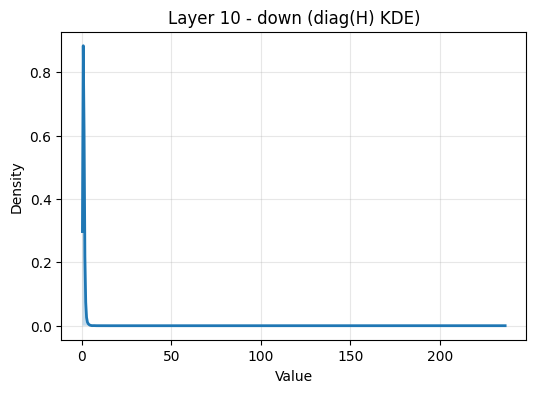

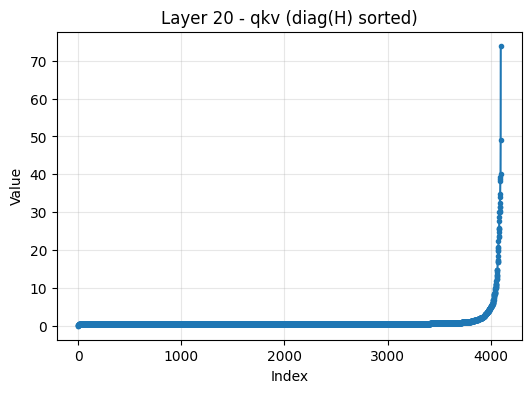

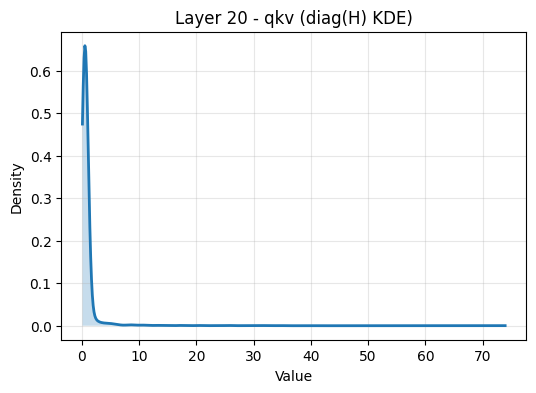

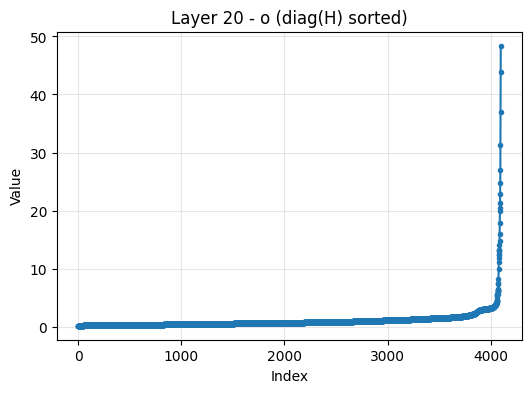

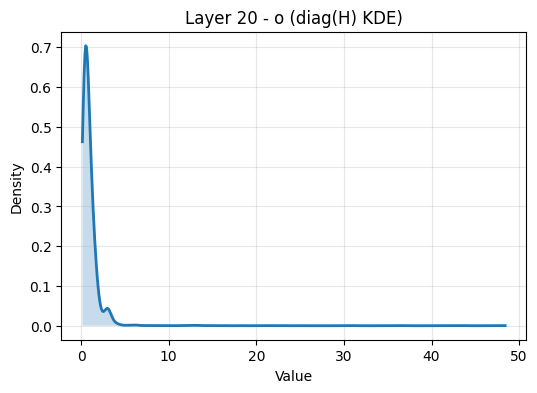

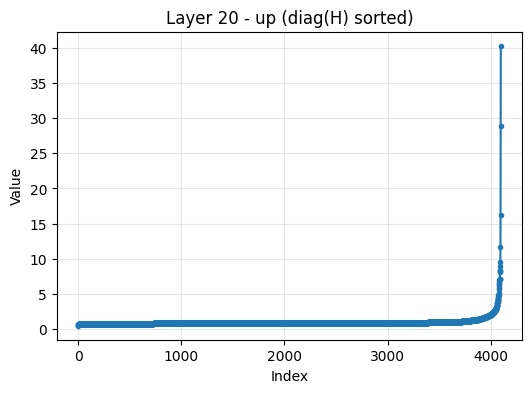

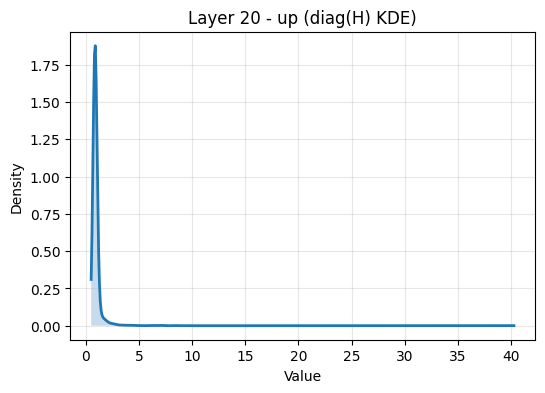

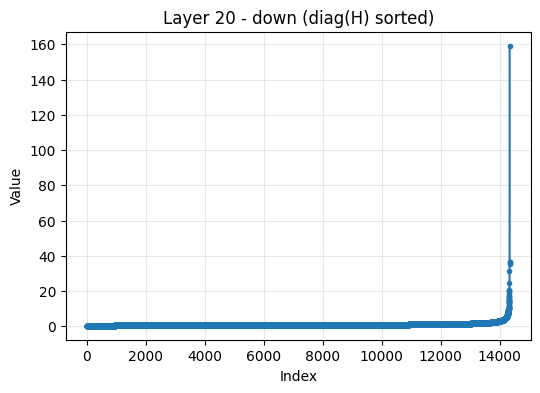

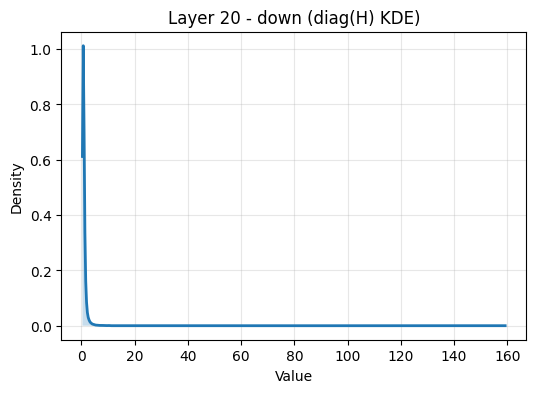

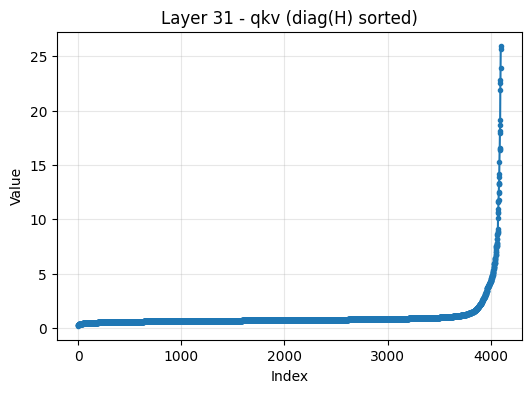

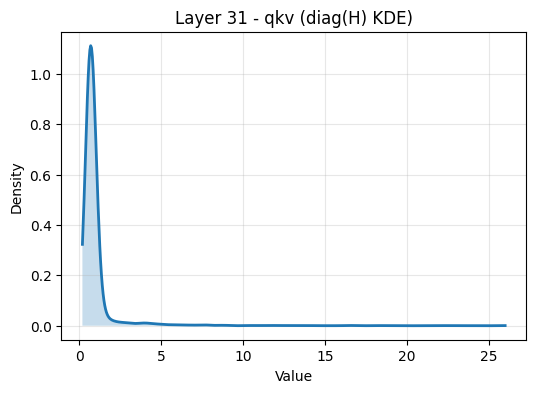

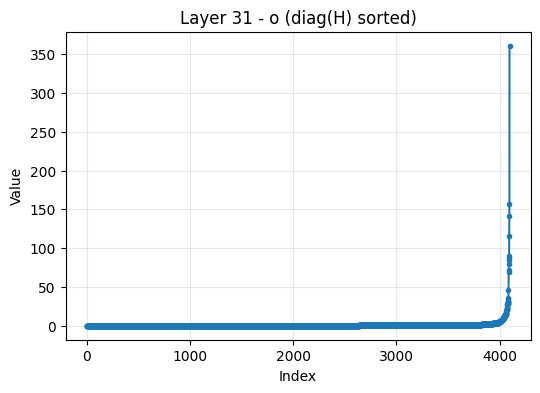

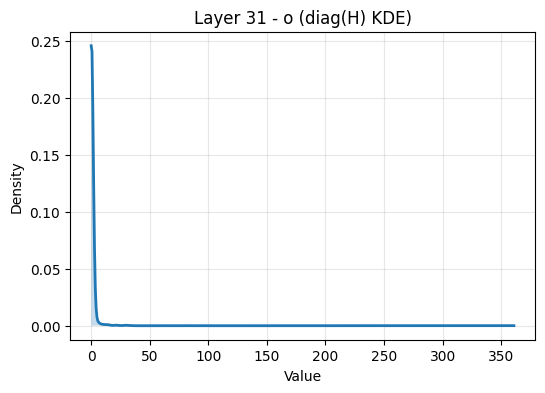

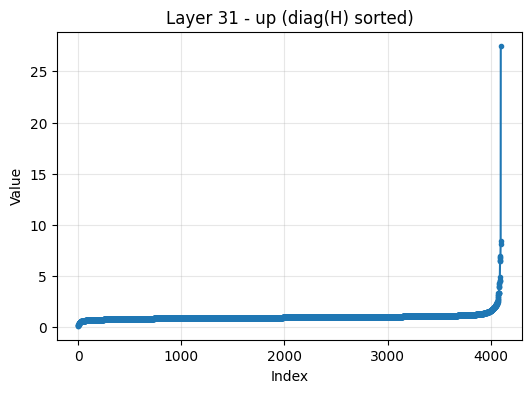

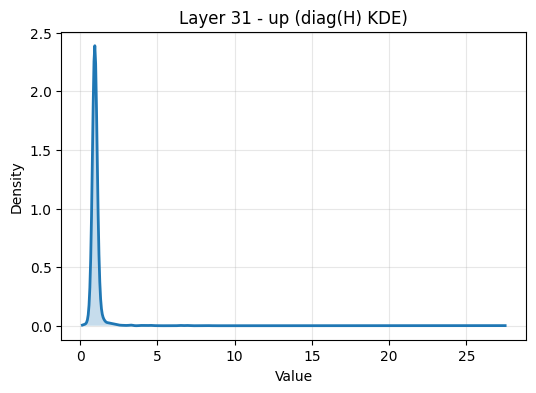

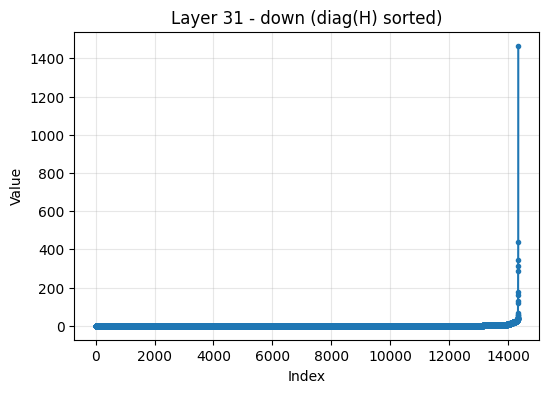

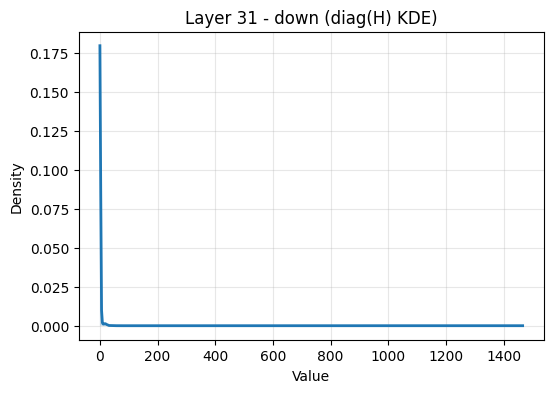

In [9]:
import matplotlib.pyplot as plt
model_list = [
    'meta-llama/Meta-Llama-3-8B',
    # 'meta-llama--Llama-2-7b-hf'
]
quip_hess_path = [
    './quip_hess/llama3_8b_6144',
    # './quip_hess/Hessians-Llama-2-7b-6144',
]
quip_hess_eig_path = [
    # './quip_hess_eig_reg0.0001/llama3_8b_6144',
    None
]

size_list = [
    1024,
    # 256,
    # 4096
]

import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

wtype_mapping = {'self_attn.q_proj': 0, 
                 'self_attn.k_proj': 1, 
                 'self_attn.v_proj': 2, 
                 'self_attn.o_proj': 3, 
                 'mlp.gate_proj': 4, 
                 'mlp.up_proj': 5, 
                 'mlp.down_proj': 6}


sigma_reg = 1e-4

for model_name, size, quip_hess, eig_path in zip(model_list, size_list, quip_hess_path, quip_hess_eig_path):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)
    
    raw_data = {}
    raw_data['weight'] = []
    raw_data['idx'] = []
    raw_data['layer_type'] = []
    raw_data['scale'] = []
        
    # for i in tqdm(range(len(layers))):
    for i in [0 ,1, 10, 20, 31]:
        named_linears = get_named_linears(layers[i])
        
        hess_dict = {}
        hess_dict['qkv'] = torch.load(f'{quip_hess}/{i}_qkv.pt', weights_only=False)
        hess_dict['o'] = torch.load(f'{quip_hess}/{i}_o.pt', weights_only=False)
        hess_dict['up'] = torch.load(f'{quip_hess}/{i}_up.pt', weights_only=False)
        hess_dict['down'] = torch.load(f'{quip_hess}/{i}_down.pt', weights_only=False)
        
        
        for k, v in hess_dict.items():
            
            H = flat_to_sym(v['flatH'], v['n']).to(device)
            mu = v['mu'].to(device)
            H.add_(mu[None, :] * mu[:, None])
            n_h = v['n']
            
            H = regularize_H(H, n_h, sigma_reg)
            # H = H/H.shape[0]
            
            diag_vals = torch.diag(H).cpu().numpy()

            # ---- 1) 정렬선 그래프 (기존) ----
            diag_sorted = np.sort(diag_vals)
            plt.figure(figsize=(6,4))
            plt.plot(diag_sorted, marker='.')
            plt.title(f"Layer {i} - {k} (diag(H) sorted)")
            plt.xlabel("Index")
            plt.ylabel("Value")
            plt.grid(True, alpha=0.3)
            plt.show()

            # ---- 2) KDE 그래프 ----
            plt.figure(figsize=(6,4))
            if np.std(diag_vals) > 0:
                kde = gaussian_kde(diag_vals)  # bw_method='scott'(default) / 'silverman' 필요시 조정
                x = np.linspace(diag_vals.min(), diag_vals.max(), 512)
                y = kde(x)
                plt.plot(x, y, lw=2)
                plt.fill_between(x, y, alpha=0.25)
            else:
                # 모든 값이 동일하면 KDE 불가 → delta 형태 표기
                x0 = diag_vals[0]
                plt.axvline(x0, linestyle='--')
                plt.text(x0, 0.5, f"value={x0:.3e}", rotation=90, va='center')

            plt.title(f"Layer {i} - {k} (diag(H) KDE)")
            plt.xlabel("Value")
            plt.ylabel("Density")
            plt.grid(True, alpha=0.3)
            plt.show()

### V1

In [ ]:
import matplotlib.pyplot as plt
model_list = [
    'meta-llama/Meta-Llama-3-8B',
    # 'meta-llama--Llama-2-7b-hf'
]

quip_hess_path = [
    './quip_hess/llama3_8b_6144',
    # './quip_hess/Hessians-Llama-2-7b-6144',
]

size_list = [
    # 1024,
    # 4096
    256
]

wtype_mapping = {'self_attn.q_proj': 0, 
                 'self_attn.k_proj': 1, 
                 'self_attn.v_proj': 2, 
                 'self_attn.o_proj': 3, 
                 'mlp.gate_proj': 4, 
                 'mlp.up_proj': 5, 
                 'mlp.down_proj': 6}
sigma_reg = 1e-4
# direction = 'col'
direction = 'row'

for model_name, size, quip_hess in zip(model_list, size_list, quip_hess_path):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)
    
    raw_data = {}
    raw_data['weight'] = []
    raw_data['idx'] = []
    raw_data['layer_type'] = []
    # raw_data['scale'] = []
    
    scale_cond_dict = {}
    
    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        
        hess_dict = {}
        hess_dict['qkv'] = torch.load(f'{quip_hess}/{i}_qkv.pt', weights_only=False)
        hess_dict['o'] = torch.load(f'{quip_hess}/{i}_o.pt', weights_only=False)
        hess_dict['up'] = torch.load(f'{quip_hess}/{i}_up.pt', weights_only=False)
        hess_dict['down'] = torch.load(f'{quip_hess}/{i}_down.pt', weights_only=False)
        
        for n, m in named_linears.items():
            
            W = m.weight.data.detach().to(device)
            
            if 'q_proj' in n or 'k_proj' in n or 'v_proj' in n:
                H_flat = hess_dict['qkv']
            elif 'o_proj' in n:
                H_flat = hess_dict['o']
            elif 'up_proj' in n or 'gate_proj' in n:
                H_flat = hess_dict['up']
            elif 'down_proj' in n:
                H_flat = hess_dict['down']
            else:
                raise NotImplementedError(n)
            
            H = flat_to_sym(H_flat['flatH'], H_flat['n']).to(device)
            mu = H_flat['mu'].to(device)
            H.add_(mu[None, :] * mu[:, None])
            n_h = H_flat['n']

            # print('before',torch.diag(H).mean())
            H = regularize_H(H, n_h, sigma_reg)
            # print('after',torch.diag(H).mean())
            
            #############################################
            
            ## row normalize
            Wr = W / W.std(dim=1, keepdim=True)
            
            ## compute scaleH
            diagH = torch.diag(H)
            diagH = torch.clamp(diagH, min=1e-8)
            scaleH = diagH.sqrt()
            
            ## compute scale
            col_std = Wr.std(dim=0, keepdim=False)
            scale_cond = scaleH / col_std
            scale_cond = scale_cond[None, :]
            
            scale_cond_dict[f'{}']
            
            #############################################
            
            ## 1
            # diagH = torch.diag(H)
            # diagW2 = torch.diag(W.T @ W)
            # diagH = torch.clamp(diagH, min=1e-8)
            # diagW2 = torch.clamp(diagW2, min=1e-8)
            # scaleWH = (diagH / diagW2).sqrt()
            # scaleWH = diagH.sqrt()
            # scaleWH = scaleWH.clamp(min=1)
            # print(scaleWH.numel())
            # print((scaleWH>=1).sum() / scaleWH.numel())
            # fig = plt.figure()
            # ax = fig.add_subplot(111)
            # ax.plot(scaleWH.cpu().numpy())
            # plt.show
            
            # (M, N) = W.shape
            # SU = (torch.randn(N).sign() + 1e-5).sign().to(device)
            # SV = (torch.randn(M).sign() + 1e-5).sign().to(device)
            # Wr = RHT_W(Wr, SU, SV)

            ## 2
            # diagH = torch.diag(H)
            # diagH = torch.clamp(diagH, min=1e-8)
            # scaleWH = diagH.sqrt()
            # Wr = W * scaleWH[None, :]
            # # W_normalized = Wr / Wr.norm(p=2, dim=1, keepdim=True)
            # W_normalized = Wr / Wr.std(dim=1, keepdim=True)
            # Wr = W_normalized
            
            ## 4 invH
            # Lhr = torch.linalg.cholesky(H)
            # H_inv = torch.cholesky_inverse(Lhr)
            # diagH_inv = torch.diag(H_inv)
            # scaleWH = 1/diagH_inv
            # scaleWH = torch.clamp(scaleWH, min=1e-8)
            # scaleWH = scaleWH.sqrt()
            # Wr = W * scaleWH[None, :]
            # # W_normalized = Wr / Wr.norm(p=2, dim=1, keepdim=True)
            # W_normalized = Wr / Wr.std(dim=1, keepdim=True)
            # Wr = W_normalized
            
            ## 3
            # W_normalized = W / W.norm(p=2, dim=1, keepdim=True)
            # Wr = W_normalized            
            
            # print(Wr.norm(p=2, dim=1)[:10])
            
            ## 6 
            # diagH = torch.diag(H)
            # diagH = torch.clamp(diagH, min=1e-8)
            # scaleWH = diagH.sqrt()
            # Wr = W * scaleWH[None, :]
            
            # ## 5 with col std
            # col_std = Wr.std(dim=0, keepdim=True)
            # col_std = col_std.expand(Wr.shape[0], Wr.shape[1])

            ## 7 with col-row scale
            # col_std = Wr.std(dim=0, keepdim=True)
            # row_std = (Wr/col_std).std(dim=1, keepdim=True)
            # col_std = row_std @ col_std
            # assert col_std.shape == Wr.shape            
                        
            ## 8 관찰용
            # diagH = torch.diag(H)
            # diagH = torch.clamp(diagH, min=1e-8)
            # scaleWH = diagH.sqrt()
            # print('scaleWH', scaleWH.mean(), scaleWH.max(), scaleWH.min())

            # W_normalized = W / W.std(dim=1, keepdim=True)
            # col_std_ = W_normalized.std(dim=0, keepdim=False)
            # print('col_std_', col_std_.mean(), col_std_.max(), col_std_.min())
            
            # Wr = W * scaleWH[None, :]
            # row_std = Wr.std(dim=1, keepdim=True)

            # W_normalized = W / row_std
            # Wr = W_normalized

            # col_std_ = Wr.std(dim=0, keepdim=False)
            # col_std = scaleWH / col_std_
            # # print(col_std.shape)
            # col_std = col_std[None, :]
            # # print(col_std.shape)      
            
            if direction == 'col':
                w = Wr.T.to('cpu')
                s = scale_cond.T.to('cpu')
            else:
                w = Wr.to('cpu')
                s = scale_cond.to('cpu')
            
            if w.shape[-1] % size == 0:
                w = w.reshape(-1, size)
                s = s.reshape(-1, size)
            else:
                raise
                D = w.shape[1]
                span = size * (D //size)
                if D < span:
                    raise ValueError("Tensor's second dimension is too small for the requested slice.")
                max_start = D - span
                start = random.randint(0, max_start)
                sliced = w[:, start : start + span]
                w = sliced.reshape(-1, size)

            # datas.append(w)

            raw_data['weight'].append(w)
            raw_data['scale'].append(s)
            
            idx = torch.tensor([i], dtype = torch.int8)
            raw_data['idx'].extend([idx] * w.shape[0])
            
            layer_type = torch.tensor([wtype_mapping[n]], dtype = torch.int8)
            raw_data['layer_type'].extend([layer_type] * w.shape[0])
    
    for k in raw_data.keys():
        # if datas[k][0].shape == torch.Size([]):
        #     datas[k] = torch.tensor(datas[k])
        # else:
        raw_data[k] = torch.cat(raw_data[k], dim = 0)
        print(f'{k} total shape: ', raw_data[k].shape)
    
    ###################### split, compute stats
    
    indices = torch.randperm(len(raw_data['weight']))
    split_index = int(len(raw_data['weight']) - 1000)
    train_indices = indices[:split_index]
    val_indices = indices[split_index:]

    dataset = {}
    dataset['train'] = {}
    dataset['val'] = {}
    for k in raw_data.keys():
        dataset['train'][k] = raw_data[k][train_indices]
        dataset['val'][k] = raw_data[k][val_indices]
        
    print('train Weight: ', dataset['train']['weight'].shape, 'val: ', dataset['val']['weight'].shape)
    print('train Scale: ', dataset['train']['scale'].shape, 'val: ', dataset['val']['scale'].shape)

    dataset_stats = {}
    for split in ['train', 'val']:
        data = dataset[split]
        
        # mean_dim0 = data['weight'].mean(dim=0)
        # std_dim0 = data['weight'].std(dim=0)
        
        mean_all = data['weight'].mean()
        std_all = data['weight'].std()
        
        dataset_stats[split] = {
            'mean': mean_all.item(),
            'std': std_all.item(),
            'mean_channel': None,
            'std_channel': None
        }
    
    ###################### split, compute stats V0
    
    # datas = torch.cat(datas, dim = 0)
    # print('total dataset shape: ', datas.shape)
    
    # indices = torch.randperm(len(datas))
    # split_index = int(len(datas) - 1000)
    # train_indices = indices[:split_index]
    # val_indices = indices[split_index:]

    # dataset = {}
    # dataset['train'] = datas[train_indices]
    # dataset['val'] = datas[val_indices]
    # print('train: ', dataset['train'].shape, 'val: ', dataset['val'].shape)

    # dataset_stats = {}
    # for split in ['train', 'val']:
    #     data = dataset[split]
        
    #     # mean_dim0 = data.mean(dim=0)
    #     # std_dim0 = data.std(dim=0)
        
    #     mean_all = data.mean()
    #     std_all = data.std()
        
    #     dataset_stats[split] = {
    #         'mean': mean_all.item(),
    #         'std': std_all.item(),
    #         # 'mean_channel': mean_dim0.tolist(),
    #         # 'std_channel': std_dim0.tolist(),
    #         'mean_channel': None,
    #         'std_channel': None,
    #     }
    
    ###################### save
    
    print('Scale stats:', dataset['train']['scale'].mean(), dataset['train']['scale'].min(), dataset['train']['scale'].max())
    os.makedirs(f'./block_pt/{model_name}', exist_ok = True)
    torch.save(dataset, f'./block_pt/{model_name}/{direction}_{size}_rnormed_scale_cond(scaleWH).pt')
    json_path = f'./block_pt/{model_name}/{direction}_{size}_rnormed_scale_cond(scaleWH)_dataset_stats.json'
    with open(json_path, 'w') as f:
        json.dump(dataset_stats, f)
    
    ## 1
    # torch.save(dataset, f'./block_pt/{model_name}/scaled3_RHT_sig{sigma_reg}_{direction}_{size}.pt')
    # json_path = f'./block_pt/{model_name}/scaled3_RHT_sig{sigma_reg}_{direction}_{size}_dataset_stats.json'
    ## 2
    # torch.save(dataset, f'./block_pt/{model_name}/scaleH_sig{sigma_reg}_std_rnormed_lidx_{direction}_{size}.pt')
    # json_path = f'./block_pt/{model_name}/scaleH_sig{sigma_reg}_std_rnormed_lidx_{direction}_{size}_dataset_stats.json'
    ## 3
    # torch.save(dataset, f'./block_pt/{model_name}/rnormed_{direction}_{size}.pt')
    # json_path = f'./block_pt/{model_name}/rnormed_{direction}_{size}_dataset_stats.json'
    ## 4
    # torch.save(dataset, f'./block_pt/{model_name}/scaleHinv_sig{sigma_reg}_std_rnormed_lidx_{direction}_{size}.pt')
    # json_path = f'./block_pt/{model_name}/scaleHinv_sig{sigma_reg}_std_rnormed_lidx_{direction}_{size}_dataset_stats.json'
    ## 5
    # torch.save(dataset, f'./block_pt/{model_name}/scaleH_sig{sigma_reg}_std_rnormed_with_col_std_lidx_{direction}_{size}.pt')
    # json_path = f'./block_pt/{model_name}/scaleH_sig{sigma_reg}_std_rnormed_with_col_std_lidx_{direction}_{size}_dataset_stats.json'
    ## 6
    # torch.save(dataset, f'./block_pt/{model_name}/scaleH_sig{sigma_reg}_with_col_std_lidx_{direction}_{size}.pt')
    # json_path = f'./block_pt/{model_name}/scaleH_sig{sigma_reg}_with_col_std_lidx_{direction}_{size}_dataset_stats.json'
    ## 7
    # torch.save(dataset, f'./block_pt/{model_name}/scaleH_sig{sigma_reg}_with_colrow_std_lidx_{direction}_{size}.pt')
    # json_path = f'./block_pt/{model_name}/scaleH_sig{sigma_reg}_with_colrow_std_lidx_{direction}_{size}_dataset_stats.json'
    # with open(json_path, 'w') as f:
    #     json.dump(dataset_stats, f)

In [ ]:
k

In [ ]:
scale = datas['scale']
print(f"Statistics for 'scale' column:")
print(f"  - Minimum value: {scale.min():.6f}")
print(f"  - Maximum value: {scale.max():.6f}")
print(f"  - Mean value: {scale.mean():.6f}")

Statistics for 'scale' column:
  - Minimum value: 1.758009
  - Maximum value: 29573.744141
  - Mean value: 78.177910

Statistics for 'scale' column:
  - Minimum value: 0.012938
  - Maximum value: 141.257156
  - Mean value: 0.908103

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# path = '/workspace/Weight_compression/Wparam_dataset/block_pt/meta-llama--Meta-Llama-3-8B/scaleH_sig0.0001_std_rnormed_with_col_std_lidx_row_1024.pt'
# # path = '/workspace/Weight_compression/Wparam_dataset/block_pt/meta-llama--Meta-Llama-3-8B/scaleH_sig0.0001_with_colrow_std_lidx_row_1024.pt'
# dataset = torch.load(path)

scale_data = np.array(dataset['train']['scale'].flatten())
# 2. Calculate min and max values
min_val = scale_data.min()
max_val = scale_data.max()

# 3. Print the results
print(f"Statistics for 'scale' column:")
print(f"  - Minimum value: {min_val:.6f}")
print(f"  - Maximum value: {max_val:.6f}")
print(f"  - Mean value: {scale_data.mean():.6f}")


Statistics for 'scale' column:
  - Minimum value: 0.000049
  - Maximum value: 34.011650
  - Mean value: 0.938580

In [ ]:
scale_data = np.array(dataset['train']['scale'].flatten())

WEIGHT_SAMPLE_SIZE = 10000 # Number of weights to sample from each matrix
scale_data = np.random.choice(scale_data, WEIGHT_SAMPLE_SIZE, replace=False)

# 2. Calculate min and max values
min_val = scale_data.min()
max_val = scale_data.max()

# 3. Print the results
print(f"Statistics for 'scale' column:")
print(f"  - Minimum value: {min_val:.6f}")
print(f"  - Maximum value: {max_val:.6f}")

# 4. Plot the distribution
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Using seaborn's histplot which is great for distributions
sns.histplot(scale_data, kde=True, ax=ax, bins=50)

ax.set_title("Distribution of 'scale' values", fontsize=16)
ax.set_xlabel("Scale Value", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)

# Add vertical lines for min and max for better visualization
ax.axvline(min_val, color='red', linestyle='--', label=f'Min: {min_val:.4f}')
ax.axvline(max_val, color='green', linestyle='--', label=f'Max: {max_val:.4f}')
ax.legend()

plt.tight_layout()
plt.show()


# Print std, mean

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt

def describe_distribution(x):
    assert isinstance(x, torch.Tensor), "Input must be a PyTorch tensor"
    x = x.flatten().float()
    n = x.numel()
    
    # 중심 경향
    mean = x.mean()
    median = x.median()

    # 산포도
    std_dev = x.std(unbiased=False)
    value_range = x.max() - x.min()
    q1 = x.kthvalue(int(0.25 * n + 1)).values
    q3 = x.kthvalue(int(0.75 * n + 1)).values
    iqr = q3 - q1

    # 모양
    skewness = ((x - mean)**3).mean() / (std_dev**3)
    kurtosis = ((x - mean)**4).mean() / (std_dev**4) - 3  # Fisher's definition

    del x
    return {
        "mean": mean.item(),
        "median": median.item(),
        "std": std_dev.item(),
        "range": value_range.item(),
        "iqr": iqr.item(),
        "skewness": skewness.item(),
        "kurtosis": kurtosis.item()
    }

model_list = [
    'meta-llama/Meta-Llama-3-8B',
    'meta-llama--Llama-2-7b-hf',
    # 'meta-llama--Llama-2-13b-hf',
]


for model_name in model_list:
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)

    # std = defaultdict(list)
    # mean = defaultdict(list)
    stats = {}
    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            W = m.weight.data.to('cuda:0')
            r = describe_distribution(W)
            for k,v in r.items():
                stats[f'{i}_{n}_{k}'] = v
            
    fig, ax = plt.subplots(1, len(r), figsize=(15, 3))
    
    for idx, k in enumerate(r.keys()):
        ax[idx].set_title(k)
        for n, m in named_linears.items():
            list = []
            for i in range(len(layers)):
                list.append(stats[f'{i}_{n}_{k}'])
            ax[idx].plot(list, label=n)
        # ax[idx].legend()
        ax[idx].set_xlabel('Layer')
    plt.legend()
    plt.show()
    

# Block with idx ltype stats
droplast

In [ ]:
model_list = [
    'meta-llama/Meta-Llama-3-8B',
    # 'meta-llama--Llama-2-7b-hf',
#     'meta-llama--Llama-2-13b-hf',
]

size_list = [
    1024
]

wtype_mapping = {'self_attn.q_proj': 0, 
                 'self_attn.k_proj': 1, 
                 'self_attn.v_proj': 2, 
                 'self_attn.o_proj': 3, 
                 'mlp.gate_proj': 4, 
                 'mlp.up_proj': 5, 
                 'mlp.down_proj': 6}

direction = 'col'
shuffle = False
drop_last = True

for model_name, size in zip(model_list, size_list):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)
    
    datas = {}
    datas['weight'] = []
    datas['idx'] = []
    datas['layer_type'] = []
    datas['mean'] = []
    datas['median'] = []
    datas['std'] = []
    datas['range'] = []
    datas['iqr'] = []
    datas['skewness'] = []
    datas['kurtosis'] = []
    
    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            w = m.weight.data.detach()
            
            stats = describe_distribution(w)
            
            if direction == 'col':
                w = w.T

            if shuffle:
                w = w.reshape(-1, 16)  # (num_rows, 16)
                indices = torch.randperm(w.size(0))  # row 인덱스 섞기
                w = w[indices]  # 섞인 순서대로 row 재배열
                
            if drop_last:
                (r, c) = w.shape
                d = (c // size) * size
                w = w[:, :d]

            w = w.reshape(-1, size)
            
            if drop_last:
                assert w.shape[0] % r == 0
                
            # if w.size(0) % size == 0:
            #     w = w.T    
            #     w = w.reshape(-1, size)
            # else:
            #     w = w.reshape(-1, size)
                
            datas['weight'].append(w)
            
            idx = torch.tensor([i], dtype = torch.int8)
            datas['idx'].extend([idx] * w.shape[0])
            
            layer_type = torch.tensor([wtype_mapping[n]], dtype = torch.int8)
            datas['layer_type'].extend([layer_type] * w.shape[0])
            
            for k, v in stats.items():
                val_tensor = torch.tensor([v], dtype=torch.float32)
                datas[k].extend([val_tensor] * w.shape[0])
    
    for k in datas.keys():
        # if datas[k][0].shape == torch.Size([]):
        #     datas[k] = torch.tensor(datas[k])
        # else:
        datas[k] = torch.cat(datas[k], dim = 0)
    
    print('total weight shape: ', datas['weight'].shape)
    
    indices = torch.randperm(len(datas['weight']))
    split_index = int(len(datas['weight']) - 1000)
    train_indices = indices[:split_index]
    val_indices = indices[split_index:]

    dataset = {}
    dataset['train'] = {}
    dataset['val'] = {}
    for k in datas.keys():
        dataset['train'][k] = datas[k][train_indices]
        dataset['val'][k] = datas[k][val_indices]
        
    print('train: ', dataset['train']['weight'].shape, 'val: ', dataset['val']['weight'].shape)

    dataset_stats = {}
    for split in ['train', 'val']:
        data = dataset[split]
        
        mean_dim0 = data['weight'].mean(dim=0)
        std_dim0 = data['weight'].std(dim=0)
        
        mean_all = data['weight'].mean()
        std_all = data['weight'].std()
        
        dataset_stats[split] = {
            'mean': mean_all.item(),
            'std': std_all.item(),
            'mean_channel': mean_dim0.tolist(),
            'std_channel': std_dim0.tolist(),
        }

    # os.makedirs(f'./block_pt/{model_name}', exist_ok = True)
    # torch.save(dataset, f'./block_pt/{model_name}/{direction}_{size}_layerwise_stats.pt')
    # json_path = f'./block_pt/{model_name}/{direction}_{size}_layerwise_stats_dataset_stats.json'
    # with open(json_path, 'w') as f:
    #     json.dump(dataset_stats, f)
        
    sub = ''
    if shuffle:
        sub += 'shuffled_'
    if drop_last:
        sub += 'droplast_'
    os.makedirs(f'./block_pt/{model_name}', exist_ok = True)
    torch.save(dataset, f'./block_pt/{model_name}/{sub}{direction}_{size}_idx_ltype_stats.pt')
    json_path = f'./block_pt/{model_name}/{sub}{direction}_{size}_idx_ltype_stats_dataset_stats.json'
    with open(json_path, 'w') as f:
        json.dump(dataset_stats, f)

# print shape

In [ ]:
# 행렬 크기 설정 (예: 5x3 행렬)
rows, cols = 1000, 3

# 열별 평균과 표준편차 정의
mean = torch.tensor([0.0, 2.0, -1.0])  # 열별 평균값
std = torch.tensor([1.0, 0.5, 2.0])    # 열별 표준편차

# 가우시안 랜덤 행렬 생성 (브로드캐스팅 활용)
random_matrix = torch.normal(mean.expand(rows, cols), std.expand(rows, cols))

print(random_matrix)
print(random_matrix.mean(0))
print(random_matrix.std(0))

In [ ]:
model_list = [
    # 'meta-llama/Meta-Llama-3-8B',
    'meta-llama--Llama-2-7b-hf',
    # 'meta-llama--Llama-2-13b-hf',
    # 'openai/clip-vit-large-patch14',
    
]

size_list = [
    1024,
    4096,
    # 5120//4,
]

for model_name, size in zip(model_list, size_list):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    # model = AutoModel.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)[0:1]

    if not isinstance(layers, dict):
        layers = {'': layers}

    for k, v in layers.items():
        print(k)
        named_linears = get_named_linears(v)
        for n, m in named_linears.items():
            print(n, m.weight.data.shape)
            W = m.weight.data
            r, c = W.shape

        # mean_c = W.mean(0)
        # std_c = W.std(0)
        # if r % size != 0:
        #     padding_size = size - r % size
        #     g = torch.normal(mean_c.expand(padding_size, c), std_c.expand(padding_size, c))
        #     W = torch.cat([W, g], dim=0)
        #     print('padding')
        #     print(n, W.shape)
        #     print(mean_c[:5], std_c[:5])
        #     print(W.mean(0)[:5], W.std(0)[:5])
        

# Block
### layerwise suffle
레이어 안에서 16 block으로 섞음
### drop last
### 8b + 7b

In [ ]:
model_list = [
    'meta-llama/Meta-Llama-3-8B',
    'meta-llama--Llama-2-7b-hf',
    # 'meta-llama--Llama-2-13b-hf',
    # 'openai--clip-vit-large-patch14',
]

size_list = [
    1024,
    1024,
    # 4096,
    # 256,
]

direction = 'col'
shuffle = False
drop_last = True
modelwise_norm = True

model_datas = []
for model_name, size in zip(model_list, size_list):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    # model = AutoModel.from_pretrained(model_path, local_files_only=True)
    # layers_ = get_blocks(model)    
    layers = get_blocks(model)    

    # datas = []    
    # for sub in layers_:
        # layers = layers_[sub]
    # if sub == 'vision':
    #     size = 1024
    # elif sub == 'text':
    #     size = 768
    # else:
    #     raise
    
    datas = []
    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            w = m.weight.data.detach()
            
            # if w.size(0) % size == 0:
            #     w = w.T    
            #     w = w.reshape(-1, size)
            # else:
            #     w = w.reshape(-1, size)
            
            if direction == 'col':
                w = w.T

            if shuffle:
                w = w.reshape(-1, 16)  # (num_rows, 16)
                indices = torch.randperm(w.size(0))  # row 인덱스 섞기
                w = w[indices]  # 섞인 순서대로 row 재배열
                
            if drop_last:
                (r, c) = w.shape
                d = (c // size) * size
                w = w[:, :d]

            w = w.reshape(-1, size)
            
            if drop_last:
                assert w.shape[0] % r == 0

            datas.append(w)
        
    datas = torch.cat(datas, dim = 0)
    if modelwise_norm:
        mu = datas.mean()
        std = datas.std()
        datas = (datas - mu) / std
        
    model_datas.append(datas)
    
model_name = 'llama8b+7b'
model_datas = torch.cat(model_datas, dim = 0)
print('total dataset shape: ', model_datas.shape)
datas = model_datas

indices = torch.randperm(len(datas))
split_index = int(len(datas) - 1000)
train_indices = indices[:split_index]
val_indices = indices[split_index:]

dataset = {}
dataset['train'] = datas[train_indices]
dataset['val'] = datas[val_indices]
print('train: ', dataset['train'].shape, 'val: ', dataset['val'].shape)

dataset_stats = {}
for split in ['train', 'val']:
    data = dataset[split]
    
    dataset_stats[split] = {
        'mean': data.mean().item(),
        'std': data.std().item(),
        # 'mean_channel': data.mean(dim=0).tolist(),
        # 'std_channel': data.std(dim=0).tolist(),
    }

# if sub != '':
#     sub = sub+ '_'
# sub = 'vision_text_'
sub = ''
if shuffle:
    sub += 'shuffled_'
if drop_last:
    sub += 'droplast_'
if modelwise_norm:
    sub += 'modelwise_norm2_'
os.makedirs(f'./block_pt/{model_name}', exist_ok = True)
torch.save(dataset, f'./block_pt/{model_name}/{sub}{direction}_{size}.pt')
json_path = f'./block_pt/{model_name}/{sub}{direction}_{size}_dataset_stats.json'
with open(json_path, 'w') as f:
    json.dump(dataset_stats, f)

## gaussian block

In [ ]:
d = torch.load('/workspace/Weight_compression/Wparam_dataset/block_pt/meta-llama--Meta-Llama-3-8B/col_1024_gaussian_padding.pt')
print(d['train'].shape)
print(d['val'].shape)

In [ ]:
dataset = {}
dataset['train'] = torch.normal(mean=0.0, std=1.0, size=d['train'].shape)
dataset['val'] = torch.normal(mean=0.0, std=1.0, size=d['val'].shape)


In [ ]:
print('train: ', dataset['train'].shape, 'val: ', dataset['val'].shape)

dataset_stats = {}
for split in ['train', 'val']:
    data = dataset[split]
    
    mean_all = data.mean()
    std_all = data.std()
    
    dataset_stats[split] = {
        'mean': mean_all.item(),
        'std': std_all.item(),
    }

sub = 'llama8b_'
direction = 'col'
size = 1024
os.makedirs(f'./block_pt/gaussian', exist_ok = True)
torch.save(dataset, f'./block_pt/gaussian/{sub}{direction}_{size}.pt')
json_path = f'./block_pt/gaussian/{sub}{direction}_{size}_dataset_stats.json'
with open(json_path, 'w') as f:
    json.dump(dataset_stats, f)

# layerwise, channelwise normalized Block

In [ ]:
model_list = [
    'meta-llama/Meta-Llama-3-8B',
    # 'meta-llama--Llama-2-7b-hf',
    # 'meta-llama--Llama-2-13b-hf',
    # 'openai--clip-vit-large-patch14',
]

size_list = [
    1024,
    # 4096,
    # 4096,
    # 256,
]

# direction = 'adapt'
direction = 'col'

for model_name, size in zip(model_list, size_list):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    # model = AutoModel.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)

        
    datas = []
    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            W = m.weight.data.detach().cuda()

            W = (W - W.mean(dim=0, keepdim=True)) / W.std(dim=0, keepdim=True)
            # W = (W - W.mean()) / W.std()
            
            if direction == 'col':
                W = W.T    
            W = W.reshape(-1, size).cpu()
                
            datas.append(W)
        
    datas = torch.cat(datas, dim = 0)
    print('total dataset shape: ', datas.shape)
    
    indices = torch.randperm(len(datas))
    split_index = int(len(datas) - 1000)
    train_indices = indices[:split_index]
    val_indices = indices[split_index:]

    dataset = {}
    dataset['train'] = datas[train_indices]
    dataset['val'] = datas[val_indices]
    print('train: ', dataset['train'].shape, 'val: ', dataset['val'].shape)

    dataset_stats = {}
    for split in ['train', 'val']:
        data = dataset[split]
        
        # mean_dim0 = data.mean(dim=0)
        # std_dim0 = data.std(dim=0)        
        # mean_all = data.mean()
        # std_all = data.std()
        
        # dataset_stats[split] = {
        #     'mean': mean_all.item(),
        #     'std': std_all.item(),
        #     'mean_channel': mean_dim0.tolist(),
        #     'std_channel': std_dim0.tolist(),
        # }
        dataset_stats[split] = {
            'mean': 0,
            'std': 1,
            'mean_channel': None,
            'std_channel': None,
        }
        


    os.makedirs(f'./block_pt/{model_name}', exist_ok = True)
    torch.save(dataset, f'./block_pt/{model_name}/{direction}_{size}_colwise_normed.pt')
    json_path = f'./block_pt/{model_name}/{direction}_{size}_colwise_normed_dataset_stats.json'
    # torch.save(dataset, f'./block_pt/{model_name}/{direction}_{size}_layerwise_normed.pt')
    # json_path = f'./block_pt/{model_name}/{direction}_{size}_layerwise_normed_dataset_stats.json'
    with open(json_path, 'w') as f:
        json.dump(dataset_stats, f)

In [ ]:
layers

# gaussian padding

size가 안 맞으면 같은 row 나 col의 mean, std를 갖는 가우시안으로 padding

In [ ]:
model_list = [
    # 'meta-llama/Meta-Llama-3-8B',
    'meta-llama--Llama-2-7b-hf',
    'meta-llama--Llama-2-13b-hf',
]

size_list = [
    # 1024,
    1024,
    1280,
]

# direction = 'adapt'
direction = 'col'

for model_name, size in zip(model_list, size_list):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)
    
    datas = []
    
    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            W = m.weight.data.detach()

            r, c = W.shape

            if direction == 'col':
                if r % size != 0:
                    padding_size = size - r % size
                    mean_c = W.mean(0)
                    std_c = W.std(0)

                    g = torch.normal(mean_c.expand(padding_size, c), std_c.expand(padding_size, c))
                    W = torch.cat([W, g], dim=0)
            elif direction =='row':
                raise NotImplementedError
            else:
                raise KeyError
            
            if direction == 'col':
                W = W.T
            
            assert W.shape[1] % size == 0
            assert W.shape[1] >= size

            W = W.reshape(-1, size)
                
            datas.append(W)
    
    datas = torch.cat(datas, dim = 0)
    print('total dataset shape: ', datas.shape)
    
    indices = torch.randperm(len(datas))
    split_index = int(len(datas) - 1000)
    train_indices = indices[:split_index]
    val_indices = indices[split_index:]

    dataset = {}
    dataset['train'] = datas[train_indices]
    dataset['val'] = datas[val_indices]
    print('train: ', dataset['train'].shape, 'val: ', dataset['val'].shape)

    dataset_stats = {}
    for split in ['train', 'val']:
        data = dataset[split]
        
        mean_dim0 = data.mean(dim=0)
        std_dim0 = data.std(dim=0)
        
        mean_all = data.mean()
        std_all = data.std()
        
        dataset_stats[split] = {
            'mean': mean_all.item(),
            'std': std_all.item(),
            'mean_channel': mean_dim0.tolist(),
            'std_channel': std_dim0.tolist(),
        }

    os.makedirs(f'./block_pt/{model_name}', exist_ok = True)
    torch.save(dataset, f'./block_pt/{model_name}/{direction}_{size}_gaussian_padding.pt')
    json_path = f'./block_pt/{model_name}/{direction}_{size}_gaussian_padding_dataset_stats.json'
    with open(json_path, 'w') as f:
        json.dump(dataset_stats, f)

# RHT smoothed Weight Block

In [ ]:
import sys
sys.path.append('/workspace/Weight_compression/Wparam_dataset')
from utils import *

def RHT_H(H, SU):
    return matmul_hadUt(matmul_hadUt(H * SU).T * SU)


def RHT_W(W, SU, SV):
    return matmul_hadUt(matmul_hadUt(W.T * SV).T * SU)


def incoherence_preprocess(H, W, args):
    # dtype_ = torch.float64 if args.use_fp64 else torch.float32
    dtype_ = torch.float32
    device = W.device
    # device = torch.device('cpu')
    (m, n) = W.shape

    def _dump(Hr, Lhr, msg=''):
        torch.save(Hr, f"{args.save_pfx}/Hr_debug_fft.pt")
        torch.save(Lhr, f"{args.save_pfx}/Lhr_debug_fft.pt")
        raise Exception(msg)

    # diagonally rescale W,H to minimize proxy loss
    scaleWH = None
    Wr = W
    Hr = H
    # if args.rescale_WH:
    if False:
        Hr = H / H.abs().max()
        diagH = torch.diag(Hr)
        diagW2 = torch.diag(W.T @ W)
        diagH = torch.clamp(diagH, min=1e-8)
        diagW2 = torch.clamp(diagW2, min=1e-8)
        scaleWH = (diagH / diagW2).sqrt().sqrt().to(torch.float32)
        scaleWH = scaleWH.clamp(min=1e-8)
        Wr = Wr * scaleWH[None, :]
        Hr = Hr / scaleWH[None, :]
        Hr = Hr / scaleWH[:, None]
        scaleWH = scaleWH.cpu()

    # randomized hadamard transformation on H, W
    if True:
        SU = (torch.randn(n, device=device).sign() + 1e-5).sign().to(dtype_)
        SV = (torch.randn(m, device=device).sign() + 1e-5).sign().to(dtype_)
        # Hr = RHT_H(Hr, SU)
        Wr = RHT_W(Wr, SU, SV)
    # randomized kronecker product on H, W
    elif args.incoh_mode == "kron":
        SU = utils.rand_ortho_butterfly_noblock(n).to(dtype_).to(device)
        SV = utils.rand_ortho_butterfly_noblock(m).to(dtype_).to(device)
        Hr = SU @ Hr @ SU.T
        Wr = SV @ Wr @ SU.T
    else:
        raise NotImplementedError
    SV = SV.cpu()
    SU = SU.cpu()

    # Lhr = torch.linalg.cholesky(Hr)
    Lhr = None
    # if not torch.all(torch.isfinite(Lhr)):
    #     return None

    Wr = Wr.to(device)

    return Lhr, Hr, Wr, SU, SV, scaleWH

In [ ]:
model_list = [
    'meta-llama/Meta-Llama-3-8B',
    'meta-llama--Llama-2-7b-hf',
    # 'meta-llama--Llama-2-13b-hf',
]

size_list = [
    4096,
    # 4096,
    # 4096,
]

# direction = 'adapt'
direction = 'col'

for model_name, size in zip(model_list, size_list):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)
    
    datas = []
    
    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            w = m.weight.data.detach()
            
            Lhr, H, w, SU, SV, scaleWH = incoherence_preprocess(None, w, None) 
            
            if direction == 'col':
                w = w.T
            
            # if w.size(0) % size == 0:
            #     w = w.T    
            #     w = w.reshape(-1, size)
            # else:
            #     w = w.reshape(-1, size)
                
            w = w.reshape(-1, size)
            
            datas.append(w)
    
    datas = torch.cat(datas, dim = 0)
    print('total dataset shape: ', datas.shape)
    
    indices = torch.randperm(len(datas))
    split_index = int(len(datas) - 1000)
    train_indices = indices[:split_index]
    val_indices = indices[split_index:]

    dataset = {}
    dataset['train'] = datas[train_indices]
    dataset['val'] = datas[val_indices]
    print('train: ', dataset['train'].shape, 'val: ', dataset['val'].shape)

    dataset_stats = {}
    for split in ['train', 'val']:
        data = dataset[split]
        
        mean_dim0 = data.mean(dim=0)
        std_dim0 = data.std(dim=0)
        
        mean_all = data.mean()
        std_all = data.std()
        
        dataset_stats[split] = {
            'mean': mean_all.item(),
            'std': std_all.item(),
            'mean_channel': mean_dim0.tolist(),
            'std_channel': std_dim0.tolist(),
        }

    os.makedirs(f'./block_pt/{model_name}', exist_ok = True)
    torch.save(dataset, f'./block_pt/{model_name}/{direction}_{size}_RHT.pt')
    json_path = f'./block_pt/{model_name}/{direction}_{size}_RHT_dataset_stats.json'
    with open(json_path, 'w') as f:
        json.dump(dataset_stats, f)